# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (urti), upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), sinusitis, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
# import sklearn
# from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
import io
import sys
from contextlib import redirect_stdout
# import miceforest as mf
%matplotlib inline

In [2]:
#os.chdir("..")
current_working_dir = os.getcwd()
# print(current_working_dir)

# !python --version
# import sklearn
# print(sklearn.__version__)
# import lifelines
# print(lifelines.__version__)

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [4]:
# def makeFilePath(pathFromWorkspace, fileName):
#     workingdir = "/workspace/" if (os.name != "nt") else ""
#     filepath = workingdir+pathFromWorkspace+fileName

#     return filepath

In [5]:
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [6]:
def create_lineplot(data, var, title, legend_title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
#     ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
#     ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
#     ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [7]:
# def create_lineplot_hue(var, hue, title, legend_title, ax1):
#     a = data_inclusions_exlusions.groupby(['date', var, hue]).size().reset_index()
#     a.columns = ['date', var, hue, 'Freq']
#     a = a[a[var] != 0]
#     sns.lineplot(x='date', y='Freq', 
#             hue=hue, 
#             data=a,
#             ax=ax1)
#     ax1.set_title(title)
#     ax1.set_ylabel('Frequency')
#     ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
#     ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
#     ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

In [8]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

## 1- Data Preparation

In [11]:
current_working_dir = os.getcwd()
print(current_working_dir)

c:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit\analysis


In [12]:
data2019_month = {}
data2019 = []

i=1
while  i < 13:
    # data of 2019
    # if (i<4):
    data2019_month["%s" %i] = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_2019-'+str(i).zfill(2)+'-01.csv.gz')
    data2019_month["%s" %i]['date'] = "2019-"+str(i).zfill(2)
    # if (i>3) and (i<7):
    #     data2019_month["%s" %i] = pd.read_csv(f'output/hospitalisation_data/input_hospitalisatio2019-'+str(i).zfill(2)+'-01.csv.gz')
    #     data2019_month["%s" %i]['date'] = "2019-"+str(i).zfill(2)
    if (i<3) or (i>11):
        data2019_month["%s" %i]['season'] = "Winter"
    elif (i>2) and (i<6):
        data2019_month["%s" %i]['season'] = "Spring"
    elif (i>5) and (i<9):
        data2019_month["%s" %i]['season'] = "Summer"
    elif (i>8) and (i<12):
        data2019_month["%s" %i]['season'] = "Autumn"

    data2019.append(data2019_month["%s" %i])
    i=i+1
    
data2019 = pd.concat(data2019_month, axis=0, ignore_index=True)

data = data2019

In [13]:
data.shape

(120000, 87)

In [14]:
data.sex.value_counts()

F    61003
M    58997
Name: sex, dtype: int64

In [16]:
data.describe(include='all')

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,sgss_positive,primary_care_covid,admitted_date,deregistered_date,died_date,...,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id,date,season
count,90000,12000,12000,12000,12000,12000,12000,36000,6000,12000,...,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000,120000
unique,40,40,40,13,13,1192,1192,1192,1186,613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,4
top,2021-05,2021-08,2020-07,2018-03,2018-04,2019-03-27,2020-07-02,2020-06-28,2019-03-02,2022-04-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01,Winter
freq,2423,358,345,1059,1039,21,20,49,14,112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,30000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,49986.955117,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,28897.508711,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24903.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49929.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75030.000000,NaN,NaN


In [17]:
data[['age', 'sex', 'smoking_status']].describe(include='all')#.transpose()#.loc[['count','mean']]

,age,sex,smoking_status
count,120000.000000,120000,78000
unique,NaN,2,4
top,NaN,F,S
freq,NaN,61003,46813
mean,40.232308,NaN,NaN
std,23.628970,NaN,NaN
min,0.000000,NaN,NaN
25%,21.000000,NaN,NaN
50%,40.000000,NaN,NaN
75%,58.000000,NaN,NaN


In [18]:
a = data['sex'].value_counts()#dropna=False, normalize=True)#.transpose()
b = data['smoking_status'].value_counts()#dropna=False, normalize=True)#.transpose()

In [19]:
a = a.rename({'F':'Female', 'M':'Male'})
b = b.rename({'S':'Smoker', 'N':'Non-smoker', 'E':'Ex-smoker', 'M':'Unknown'})

In [20]:
a

Female    61003
Male      58997
Name: sex, dtype: int64

In [21]:
c = pd.concat([a, b])
c

Female        61003
Male          58997
Smoker        46813
Non-smoker    15608
Ex-smoker      7798
Unknown        7781
dtype: int64

In [22]:
d = pd.DataFrame(c, columns = ['Freq'])
d

,Freq
Female,61003
Male,58997
Smoker,46813
Non-smoker,15608
Ex-smoker,7798
Unknown,7781


### 1-2- Additional variables
#### 1-2-1- Calculating Chalson Comorbidity Index
Based on: https://www.nature.com/articles/4500889.pdf?origin=ppub

In [23]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')

col18 = data.columns.get_loc('age')

In [24]:
for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1:
        n=n+1
    if data.iat[idx, col2] == 1:
        n=n+1 
    if data.iat[idx, col17] == 1:
        n=n+1 
    if data.iat[idx, col3] == 1:
        n=n+1
    if data.iat[idx, col7] == 1:
        n=n+1
    if data.iat[idx, col6] == 1:
        n=n+1
    if data.iat[idx, col16] == 1:
        n=n+1
    if data.iat[idx, col5] == 1:
        n=n+1
    if data.iat[idx, col12] == 1:
        n=n+1
    
    if data.iat[idx, col9] == 1:
        n=n+2
    if data.iat[idx, col14] == 1:
        n=n+2
    if data.iat[idx, col8] == 1:
        n=n+2
    if data.iat[idx, col1] == 1:
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma
    #    n=n+2

    if data.iat[idx, col13] == 1:
        n=n+3

    if data.iat[idx, col11] == 1:
        n=n+6
    if data.iat[idx, col10] == 1:
        n=n+6

    #age component
    if data.iat[idx, col18] <= 40:
        n=n+0
    if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
        n=n+1
    if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
        n=n+2
    if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
        n=n+3
    if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
        n=n+4
    
    data.iat[idx, col0]=n

#data.CCI.value_counts()

#### 1-2-2- Calculating all meds except abs

In [25]:
#generate meds_noabs in the one month before
data['meds_nonabs'] = data['all_meds_one_month'] - data['antibacterial_brit_one_month']

# assign zero for any row with negative values which could be the case because of using dummy data and/or the inconsistency of the two codelists of all_meds and antibacterial_brit
data['meds_nonabs'][data['meds_nonabs'] < 0] = 0

data['meds_nonabs'].value_counts()
# data[['all_meds_one_month', 'antibacterial_brit_one_month', 'meds_nonabs']]

0    79755
2    13569
3    11294
1    10523
4     4217
5      599
6       43
Name: meds_nonabs, dtype: int64

### 1-3- Handling variables with missing values
#### 1-3-1- Drop variables with many missing values
We drop colmns with more than 50 percent missing values as they may not be usable in the prediction model, nor they can be imputed properly.

In [26]:
#dropping any variable with more than 50 percent missing values
perc = 50.0
# min_count =  int(((100-perc)/100)*data.shape[0] + 1)
# data = data.drop(['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd'], axis=1, thresh=min_count)
# data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd']] = data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd']].dropna(axis=1, thresh=min_count)
data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd']] = data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd']].loc[:, data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd']].isnull().mean() < perc]
data.shape

(120000, 89)

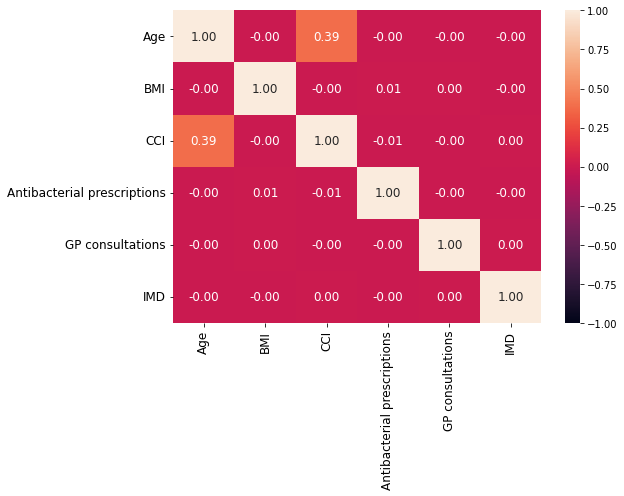

In [27]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd' ]].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti.jpg')
plt.show()

#### 1-3-2- Imputation of missing values
We impute variables with missing values that at most 50 pecent of their values are missing.

In [28]:
# prep before plot
data['age'][data['age'] < 0] = np.nan

## remove died cases
#data.died_date.value_counts()

# remove cases with bmi equal 0
data['bmi'][data['bmi'] <= 0] = 0

# remove cases with negative gp_count
data['gp_count'][data['gp_count'] < 0] = np.nan

# remove cases with negative antibacterial_brit
data['antibacterial_brit'][data['antibacterial_brit'] < 0] = np.nan

In [29]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data = data.replace({"sex": dict_sex})
data = data.replace({"smoking_status": dict_smoking})

In [30]:
# # if ('bmi' in data.columns) and (data['bmi'].isnull().sum() > 0):
# if ('bmi' in data.columns):    
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=0)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi']])# 'CCI']])
#     # data['bmi_imp'] = np.nan
#     data['bmi_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi']]))[:,3]
    
#     # # KNN imputation with sklearn package
#     # imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=0)
#     # data['bmi_imp_knn'] = np.nan
#     # data['bmi_imp_knn'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi']]))[:,3]

#     # # multiple imputation with miceforest package
#     # ## create kernel
#     # kernel = mf.ImputationKernel(data[['age', 'sex', 'CCI', 'bmi']], save_all_iterations=True)
#     # ## run the MICE algorithm for 3 iterations on each of the datasets
#     # kernel.mice(3)
#     # ## fillmissing data and view imputed data
#     # a = kernel.complete_data(2)#[:,2]
#     # data['bmi_imp_mul'] = a.bmi

In [31]:
data['bmi'] = data['bmi'].replace(0, np.nan)

In [32]:
# if ('bmi' in data.columns):
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi']])#'bmi_imp']])
#     # data['imd_imp'] = np.nan
#     data['bmi_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi']]))[:,3]

In [33]:
# drop bmi values equal 0
if ('bmi' in data.columns):
    data['bmi_imp'] = data['bmi']
    data = data[data['bmi_imp'].notna()]

In [34]:
# data[['age', 'sex', 'CCI', 'bmi', 'bmi_imp']]
data['bmi_imp'].min()

0.1266561985970682

In [35]:
# # if ('imd' in data.columns) and (data['imd'].isnull().sum() > 0):
# if ('imd' in data.columns):
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=0)
#     imputer.fit(data[['age', 'sex', 'CCI', 'imd']])#'bmi_imp']])
#     # data['imd_imp'] = np.nan
#     data['imd_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'imd']]))[:,3]

#     # # KNN imputation with sklearn package
#     # imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=0)
#     # data['imd_imp_knn'] = np.nan
#     # data['imd_imp_knn'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd']]))[:,4]
    
#     # # multiple imputation
#     # ## create kernel
#     # kernel = mf.ImputationKernel(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd']], save_all_iterations=True)
#     # ## run the MICE algorithm for 3 iterations on each of the datasets
#     # kernel.mice(3)
#     # ## fillmissing data and view imputed data
#     # a = kernel.complete_data(2)#[:,2]
#     # data['imd_imp'] = a.imd

In [36]:
data['imd_imp'] = data['imd']

In [37]:
# if ('smoking_status' in data.columns) and (data['smoking_status'].isnull().sum() > 0):
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'smoking_status']])#'imd']]) # 'imd_imp'
#     # data['smoking_status_imp'] = np.nan
#     data['smoking_status_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'smoking_status']]))[:,4]

#     # # KNN imputation with sklearn package
#     # # imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=np.nan)
#     # data['smoking_status_imp_knn'] = np.nan
#     # data['smoking_status_imp_knn'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status']]))[:,5]

#     # # multiple imputation
#     # ## create kernel
#     # kernel = mf.ImputationKernel(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status']], save_all_iterations=True)
#     # ## run the MICE algorithm for 3 iterations on each of the datasets
#     # kernel.mice(3)
#     # ## fillmissing data and view imputed data
#     # a = kernel.complete_data(2)#[:,2]
#     # data['smoking_status_imp'] = a.smoking_status

In [38]:
if ('smoking_status' in data.columns) and (data['smoking_status'].isnull().sum() > 0):
    data['smoking_status_imp'] = data['smoking_status'].replace(np.nan, 0)
    data['smoking_status_imp'].value_counts()

In [39]:
# if ('ethnicity' in data.columns) and (data['ethnicity'].isnull().sum() > 0):
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity']])# 'smoking_status_imp']]) #'imd_imp'
#     # data['ethnicity_imp'] = np.nan
#     data['ethnicity_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity']]))[:,5] #'imd_imp'

#     # # KNN imputation with sklearn package
#     # imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=np.nan)
#     # data['ethnicity_imp'] = np.nan
#     # data['ethnicity_imp'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status_imp', 'ethnicity']]))[:,6]

#     # # multiple imputation
#     # ## create kernel
#     # kernel = mf.ImputationKernel(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status_imp', 'ethnicity']], save_all_iterations=True)
#     # ## run the MICE algorithm for 3 iterations on each of the datasets
#     # kernel.mice(3)
#     # ## fillmissing data and view imputed data
#     # a = kernel.complete_data(2)#[:,2]
#     # data['ethnicity_imp'] = a.ethnicity

In [40]:
if ('ethnicity' in data.columns) and (data['ethnicity'].isnull().sum() > 0):
    data['ethnicity_imp'] = data['ethnicity'].replace(np.nan, 0)
    data['ethnicity_imp'].value_counts()

In [41]:
# if ('gp_count' in data.columns) and (data['gp_count'].isnull().sum() > 0):
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'gp_count']])# 'ethnicity_imp']]) # 'imd_imp'
#     # data['gp_count_imp'] = np.nan
#     data['gp_count_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'gp_count']]))[:,6] #'imd_imp'

#     # # KNN imputation with sklearn package
#     # imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=np.nan)
#     # data['gp_count_imp'] = np.nan
#     # data['gp_count_imp'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status_imp', 'ethnicity_imp', 'gp_count']]))[:,7]

#     # # multiple imputation
#     # ## create kernel
#     # kernel = mf.ImputationKernel(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status_imp', 'ethnicity_imp', 'gp_count']], save_all_iterations=True)
#     # ## run the MICE algorithm for 3 iterations on each of the datasets
#     # kernel.mice(3)
#     # ## fillmissing data and view imputed data
#     # a = kernel.complete_data(2)#[:,2]
#     # data['gp_count_imp'] = a.gp_count

In [42]:
# drop gp_count value missing
if ('gp_count' in data.columns) and (data['gp_count'].isnull().sum() > 0):
    data['gp_count_imp'] = data['gp_count']
    data = data[data['gp_count_imp'].notna()]

In [43]:
# # if ('antibacterial_brit' in data.columns) and (data['antibacterial_brit'].isnull().sum() > 0):
# if ('antibacterial_brit' in data.columns) and (data['antibacterial_brit'].isnull().sum() >= 0):    
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'ethnicity_imp', 'antibacterial_brit']])# 'gp_count']]) #'imd_imp'
#     # data['antibacterial_brit_imp'] = np.nan
#     data['antibacterial_brit_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'ethnicity_imp', 'antibacterial_brit']]))[:,7] # 'imd_imp'

#     # # KNN imputation with sklearn package
#     # imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=np.nan)
#     # data['antibacterial_brit_imp'] = np.nan
#     # data['antibacterial_brit_imp'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status_imp', 'ethnicity_imp', 'gp_count', 'antibacterial_brit']]))[:,8]

#     # # multiple imputation
#     # ## create kernel
#     # kernel = mf.ImputationKernel(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status_imp', 'ethnicity_imp', 'gp_count', 'antibacterial_brit']], save_all_iterations=True)
#     # ## run the MICE algorithm for 3 iterations on each of the datasets
#     # kernel.mice(3)
#     # ## fillmissing data and view imputed data
#     # a = kernel.complete_data(2)#[:,2]
#     # data['antibacterial_brit_imp'] = a.antibacterial_brit

In [44]:
# drop antibacterial_brit value missing
if ('antibacterial_brit' in data.columns) and (data['antibacterial_brit'].isnull().sum() >= 0):
    data['antibacterial_brit_imp'] = data['antibacterial_brit']
    data = data[data['antibacterial_brit_imp'].notna()]

### 1-4- Translating states with dictionaries

In [45]:
# define dictionaries
dict_sex = {0: 'Female', 1: 'Male'}
# dict_BMI_cat= {'Underweight': 'Underweight', 'Healthy weight': 'Healthy weight', 'Overweight': 'Overweight', 'Obese': 'Obese', 
#                 np.nan: 'Unknown'}
# dict_imd = {0: 'Unknown', 1: '1 (most deprived)', 2: '2', 3: '3', 4: '4', 5: '5 (least deprived)', np.nan: 'Unknown'}
# dict_ethnicity = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown', np.nan: 'Unknown'}
dict_ethnicity_imp = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown'}
# dict_smoking_imp = {1:'Smoker', 2:'Ex-smoker', 3:'Never smoked'}
dict_smoking_imp = {1:'Smoker', 2:'Ex-smoker', 3:'Never smoked', 0: 'Unknown'}
# dict_smoking = {'E': 'Ex-smoker', 'M': 'Unknown', 'S': 'Smoker', 'N': 'Never smoked'}
# dict_smoking_status= {'Smoker': 'Smoker', 'Never smoked': 'Never smoked', 'Ex-smoker': 'Ex-smoker', 'Unknown': 'Unknown', 
#                        np.nan: 'Unknown'}
# dict_gp_count_cat= {'Few': 'Few', 'Some': 'Some', 'Many': 'Many', 'Too many': 'Too many', np.nan: 'Unknown'}
dict_flu = {0: 'No', 1: 'Yes'}

In [46]:
# reoplace values of dictionaries with existing ones
data = data.replace({"sex": dict_sex})
# data = data.replace({"BMI_cat": dict_BMI_cat})
# data = data.replace({"imd": dict_imd_imp})
data = data.replace({"ethnicity_imp": dict_ethnicity_imp})
data = data.replace({"smoking_status_imp": dict_smoking_imp})
# data = data.replace({"smoking_status": dict_smoking_status})
# data = data.replace({"gp_count_cat": dict_gp_count_cat})
data = data.replace({"flu_vaccine": dict_flu})

In [47]:
# categorising
data['BMI_cat'] = pd.cut(data['bmi_imp'], right=False, bins=[0,18.5,25,30,200], labels=['Underweight', 'Healthy weight', 
                                                                                        'Overweight', 'Obese'])
data['gp_count_cat'] = pd.cut(data['gp_count_imp'], right=False, bins=[0,3,8,12,100], labels=['Few', 'Some', 'Many', 'Too many'])
data['CCI_cat'] = pd.cut(data['CCI'], right=False, bins=[0,1,3,5,8,99], labels=['No', 'Low', 'Moderate', 'High', 'Very high'])
data['Age_cat'] = pd.cut(data['age'], right=False, bins=[0,18,60,200], labels=['0-17 years', '18-59 years', '>59 years'])
#data.CCI_cat.value_counts()

In [48]:
data.describe(include='all')

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,sgss_positive,primary_care_covid,admitted_date,deregistered_date,died_date,...,bmi_imp,imd_imp,smoking_status_imp,ethnicity_imp,gp_count_imp,antibacterial_brit_imp,BMI_cat,gp_count_cat,CCI_cat,Age_cat
count,89469,8941,8952,8956,8959,8938,8983,26774,4473,9032,...,89469.000000,89469.000000,89469,89469,89469.000000,89469.000000,89469,89469,89469,89469
unique,40,40,40,13,13,1191,1192,1192,1170,581,...,NaN,NaN,4,4,NaN,NaN,4,4,5,3
top,2021-05,2022-03,2020-07,2018-03,2018-07,2019-03-27,2021-05-25,2020-08-07,2019-03-02,2022-03-30,...,NaN,NaN,Unknown,White,NaN,NaN,Obese,Few,Low,18-59 years
freq,2407,264,265,777,785,18,17,38,11,87,...,NaN,NaN,37223,53796,NaN,NaN,61771,44032,22493,49719
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.939275,2.849423,NaN,NaN,3.343437,1.255250,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.979941,1.524415,NaN,NaN,3.538261,1.450691,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.126656,0.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.194092,2.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.943754,3.000000,NaN,NaN,3.000000,0.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,41.725503,4.000000,NaN,NaN,6.000000,3.000000,NaN,NaN,NaN,NaN


In [250]:
# save data
# data.to_csv("../output/hospitalisation_prediction_urti/data_imputed.csv")

# input_file_path = makeFilePath("output/hospitalisation_prediction_urti/", "data_imputed.csv")
# data = pd.read_csv(input_file_path)

# data = pd.read_csv('output/hospitalisation_prediction_urti/data_imputed.csv')
# data.shape#head()

### 1-5- Polynimial featuring

In [49]:
X = data[['age','bmi_imp', 'CCI']]
poly = PolynomialFeatures(3)#, interaction_only=True)
X_poly = poly.fit_transform(X)
X_poly = pd.DataFrame(X_poly)#, columns=['one', 'age', 'bmi', 'poly_age_bmi_1', 'poly_age_bmi_2', 'poly_age_bmi_3'])
# X = pd.concat([X, X_poly], axis=1)
X_poly

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.0,36.0,28.149536,0.0,1296.0,1013.383295,0.0,792.396376,0.000000,0.0,46656.0,36481.798631,0.0,28526.269533,0.000000,0.0,22305.590294,0.000000,0.000000,0.0
1,1.0,38.0,14.994380,1.0,1444.0,569.786435,38.0,224.831428,14.994380,1.0,54872.0,21651.884524,1444.0,8543.594245,569.786435,38.0,3371.207829,224.831428,14.994380,1.0
2,1.0,46.0,31.462364,11.0,2116.0,1447.268745,506.0,989.880350,346.086004,121.0,97336.0,66574.362285,23276.0,45534.496113,15919.956199,5566.0,31143.975925,10888.683853,3806.946047,1331.0
3,1.0,30.0,34.050204,8.0,900.0,1021.506117,240.0,1159.416385,272.401631,64.0,27000.0,30645.183501,7200.0,34782.491549,8172.048934,1920.0,39478.364302,9275.331080,2179.213049,512.0
4,1.0,10.0,37.375582,3.0,100.0,373.755818,30.0,1396.934116,112.126745,9.0,1000.0,3737.558182,300.0,13969.341163,1121.267455,90.0,52211.225361,4190.802349,336.380236,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89464,1.0,0.0,44.303059,2.0,0.0,0.000000,0.0,1962.761012,88.606117,4.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,86956.316397,3925.522025,177.212235,8.0
89465,1.0,22.0,43.391026,5.0,484.0,954.602567,110.0,1882.781117,216.955129,25.0,10648.0,21001.256468,2420.0,41421.184563,4773.012834,550.0,81695.803927,9413.905583,1084.775644,125.0
89466,1.0,8.0,35.972336,3.0,64.0,287.778687,24.0,1294.008947,107.917008,9.0,512.0,2302.229495,192.0,10352.071573,863.336060,72.0,46548.524425,3882.026840,323.751023,27.0
89467,1.0,55.0,22.146660,6.0,3025.0,1218.066273,330.0,490.474527,132.879957,36.0,166375.0,66993.645005,18150.0,26976.099000,7308.397637,1980.0,10862.372352,2942.847164,797.279742,216.0


In [50]:
# add a column with second degree of age values
data['age_pol_deg_2'] = X_poly[3]
# add a column with values of multiplocation of age, bmi_imp, and cci
data['age_pol_bmi_imp_cci'] = X_poly[5]

## 2- Plots
### 2-1- Continuous factors

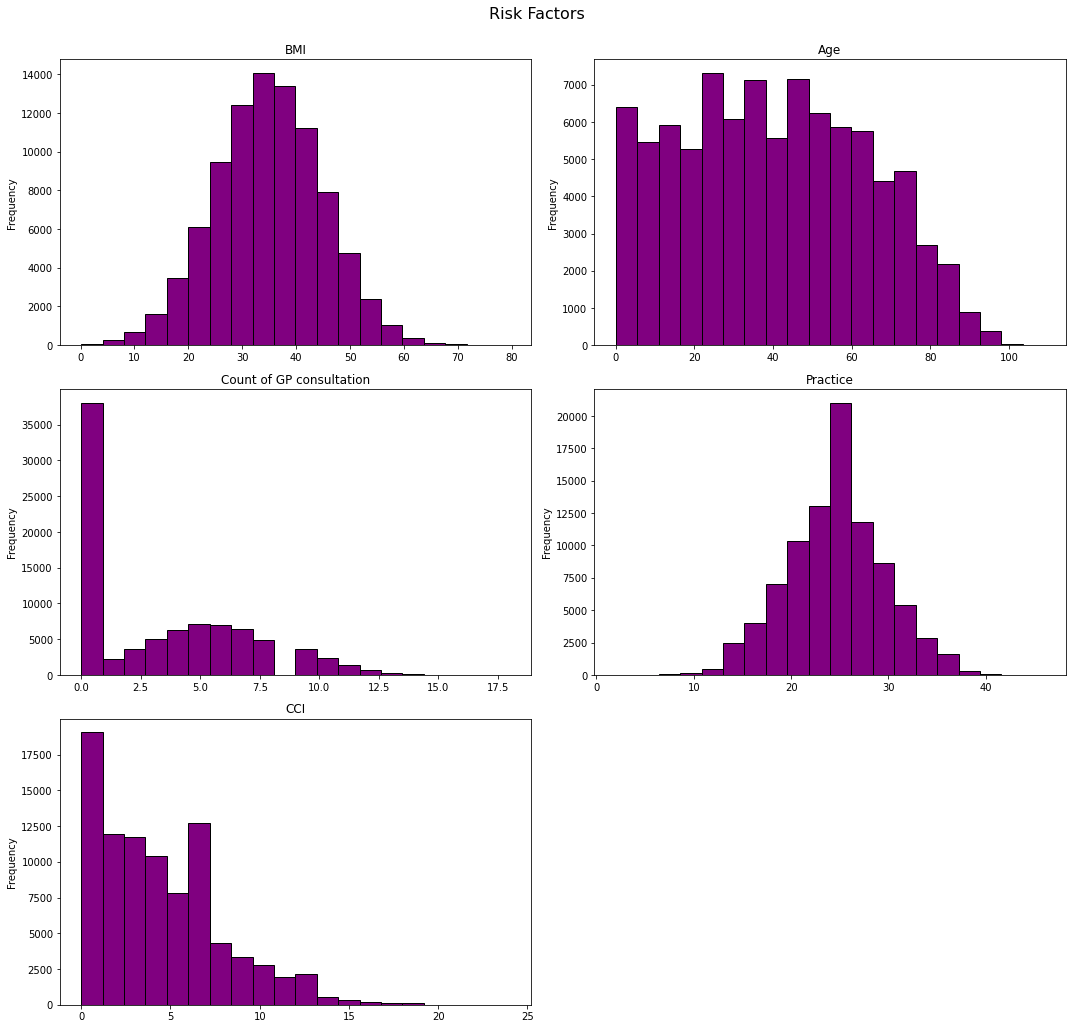

In [51]:
fig, axes = plt.subplots(3,2, 
                        figsize=(15, 15)
                        )
create_histplot('BMI', data['bmi'], axes[0,0])
create_histplot('Age', data['age'], axes[0,1])
create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
create_histplot('Practice', data['practice'], axes[1,1])
create_histplot('CCI', data['CCI'], axes[2,0])
fig.delaxes(ax=axes[2,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cont.jpg')
plt.show()

In [52]:
# p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count', 'CCI'#, 'practice'
#                              ], 
#                 hue = 'admitted', # 'antibacterial_brit', 
# #                kind='reg', 
#                 #markers=["o", "s"], 
#                 diag_kind="kde",#"hist"
# #                plot_kws={#'line_kws':{'color':'red'}, 
#                 plot_kws={'alpha':0.3},
#                 height = 3)

# p.axes[0,2].set_xlim((0,20))
# p.axes[0,2].set_ylim((0,100))

# p.axes[1,1].set_xlim((0,75))
# p.axes[1,1].set_ylim((0,75))

# p.axes[2,0].set_xlim((0,100))
# p.axes[2,0].set_ylim((0,20))

# p.axes[0,3].set_xlim((0,20))
# p.axes[3,0].set_ylim((0,20))

# plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cont_pairplot.jpg')
# plt.show()

### 2-2- Categorical factors

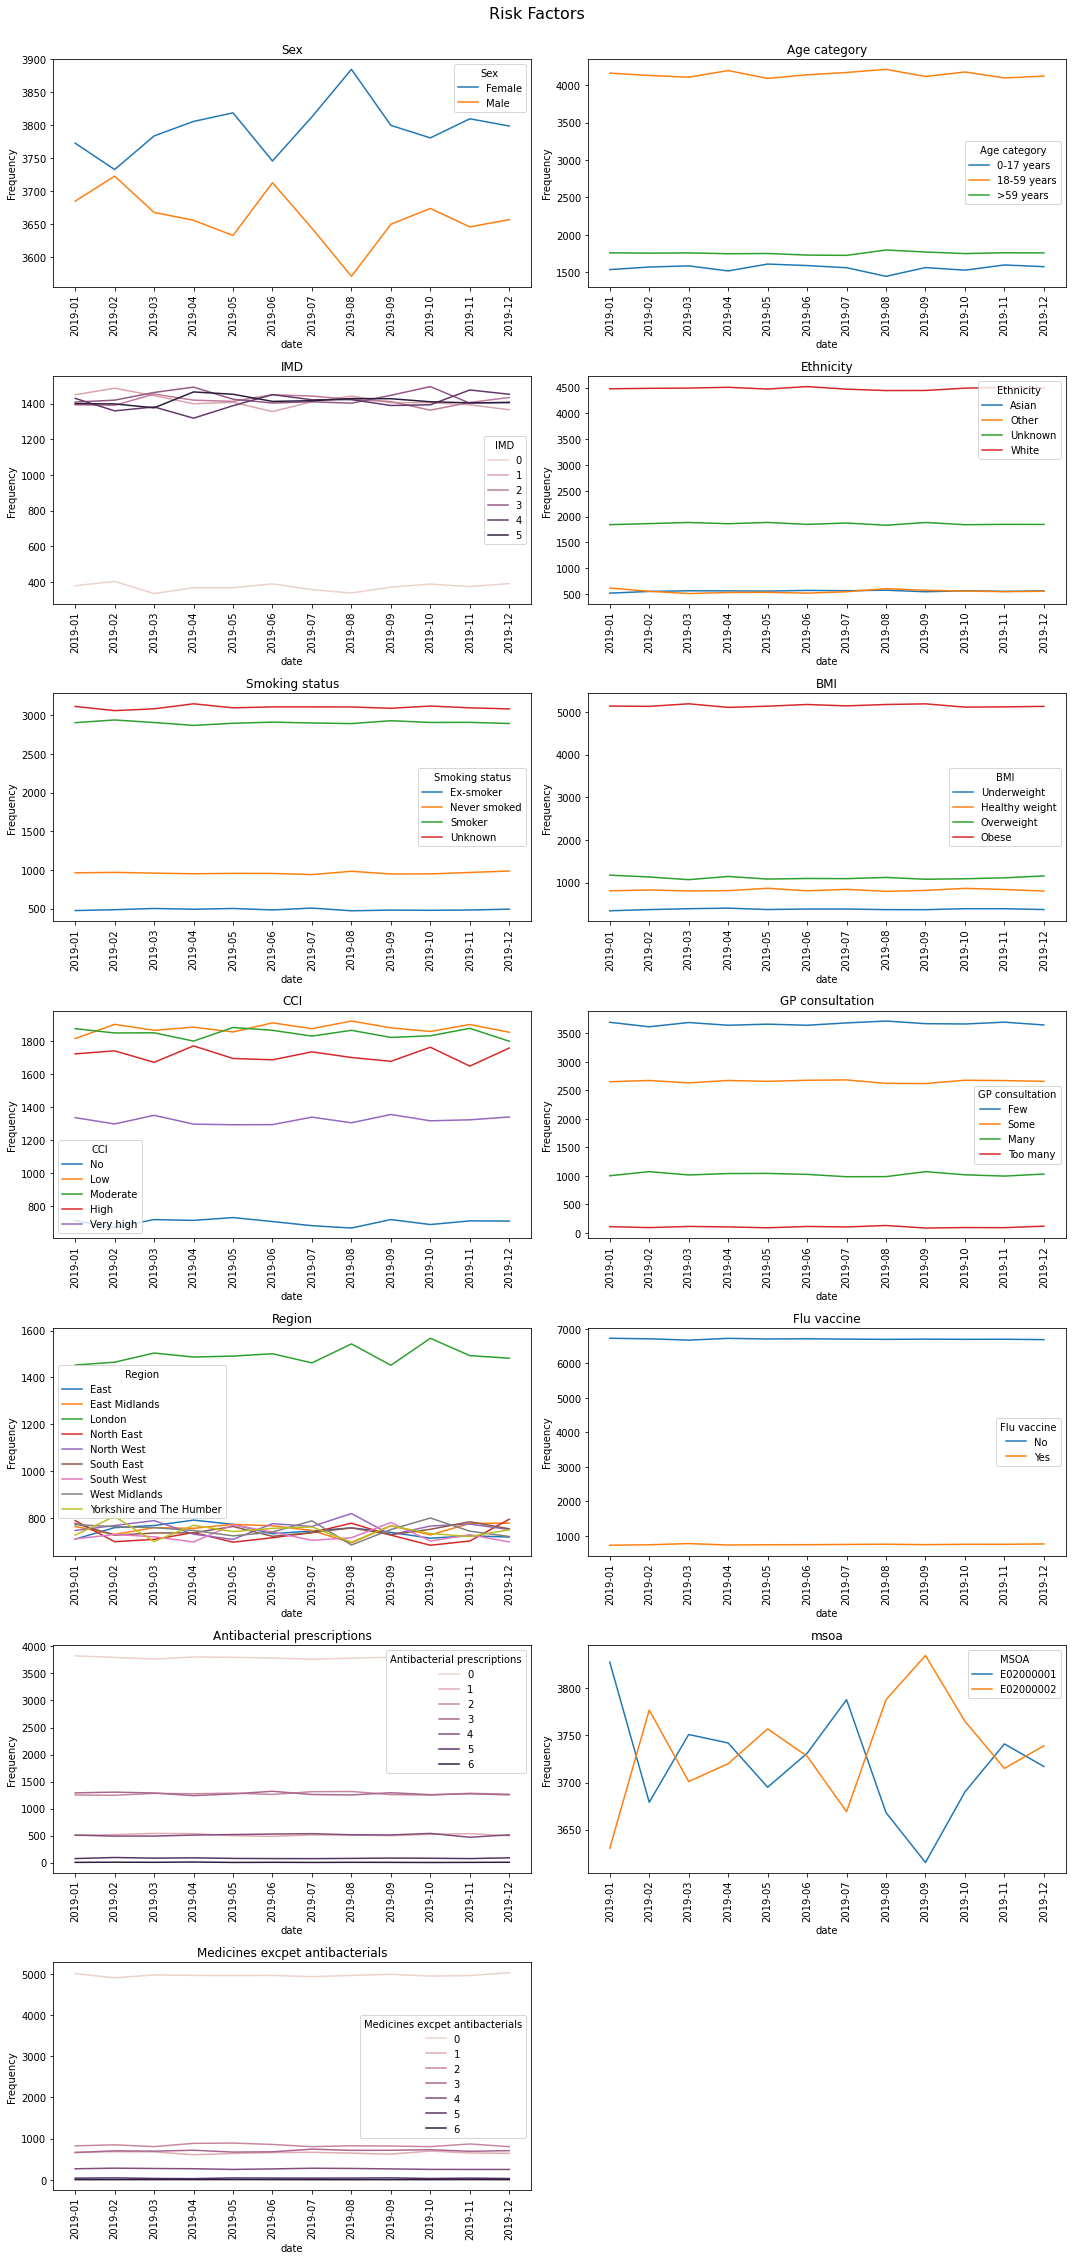

In [53]:
fig, axes = plt.subplots(7,2,
                        figsize=(15, 33)
                        )
create_lineplot(data, 'sex', 'Sex', 'Sex', axes[0,0])
create_lineplot(data, 'Age_cat', 'Age category', 'Age category', axes[0,1])
create_lineplot(data, 'imd_imp', 'IMD', 'IMD', axes[1,0])
create_lineplot(data, 'ethnicity_imp', 'Ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data, 'smoking_status_imp', 'Smoking status', 'Smoking status', axes[2,0])
create_lineplot(data, 'BMI_cat', 'BMI', 'BMI', axes[2,1])
create_lineplot(data, 'CCI_cat', 'CCI', 'CCI', axes[3,0])
create_lineplot(data, 'gp_count_cat', 'GP consultation', 'GP consultation', axes[3,1])
create_lineplot(data, 'region', 'Region', 'Region', axes[4,0])
create_lineplot(data, 'flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
create_lineplot(data, 'antibacterial_brit_imp', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
create_lineplot(data, 'msoa', 'msoa', 'MSOA', axes[5,1])
create_lineplot(data, 'meds_nonabs', 'Medicines excpet antibacterials', 'Medicines excpet antibacterials', axes[6,0])
fig.delaxes(ax=axes[6,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat.jpg')
plt.show()

### Adding summary table 